In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from sensitivity_tests import *

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os
import numpy as np
import math
import random
import sys
import itertools
from scipy import stats
import pandas as pd
sys.path.append("~/rankability_toolbox")
import pyrankability

from gurobipy import *
setParam("OutputFlag", 0)
setParam("Presolve", 0)

In [5]:
# Produces a pandas Series with the optimal rankings found from each permutation
def solve_all_permutations(D_orig):
    perms = list(itertools.permutations(range(D_orig.shape[0])))
    P_elems = []
    for perm in tqdm(perms):
        D_permuted = D_orig[perm,:][:,perm]
        k, details = pyrankability.lop.bilp(D_permuted)
        elem = list(details["P"][0])
        for i in range(len(elem)):
            elem[i] = perm[elem[i]]
        P_elems.append(str(elem))
    return pd.Series(P_elems)

# Checks if the frequencies are uniform or not
def check_freqs(freqs):
    if len(freqs.unique()) > 1:
        print(freqs)
        plt.bar(range(1, len(freqs)+1), height=freqs.values)
        plt.show()
        return False
    else:
        print("Perfectly balanced, as all things should be.")
        print("All {0} elements produced by {1} permutations".format(len(freqs), freqs.unique()[0]), flush=True)
        return True  

# Generates random noisy D matrices and checks for uniform frequency
def test_rand_D(noise_gen, num_attempts):
    for i in range(num_attempts):
        D2 = noise_gen.apply_noise(D)
        print(D2)
        P_elems_series = solve_all_permutations(D2)
        freqs = P_elems_series.value_counts()
        check_freqs(freqs)

def test_rand_D_correlate_sensitivity(noise_gen, num_attempts):
    for i in range(num_attempts):
        D2 = noise_gen.apply_noise(D)
        print(D2)
        P_elems_series = solve_all_permutations(D2)
        freqs = P_elems_series.value_counts()
        if not check_freqs(freqs):
            D2_P = pd.Series(freqs.index.values)
            D2_P_counts = D2_P.copy(deep=True)
            D2_P_counts.loc[:] = 0
            noise_gen2 = BinaryFlipNoise(0.05)
            # Try 20 at a time and plot
            for j in range(5):
                for k in range(20):
                    D3 = noise_gen2.apply_noise(D2)
                    D3_P = solve_all_permutations(D3).unique()
                    D2_P_counts = D2_P_counts.add(D2_P.isin(D3_P).astype(int))
                plt.bar(range(1, len(D2_P_counts)+1), height=D2_P_counts.values)
                plt.show()

## Perfect Dominance with Constant # of Ties

In [6]:
n_items = 7
n_ties = 4

# Create perfect binary dominance
D = PerfectBinarySource(n_items).init_D()

# Tie-up the bottom n_ties items
for i in range(n_ties):
    D[n_items-i-1] = 0

D

array([[0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

100%|██████████| 5040/5040 [00:29<00:00, 169.02it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations


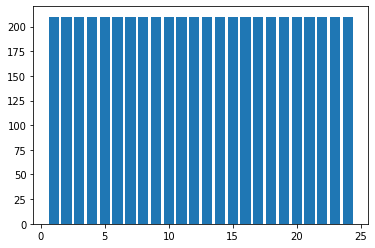

In [7]:
n_ties_series = solve_all_permutations(D)
freqs = n_ties_series.value_counts()
check_freqs(freqs)
plt.bar(range(1, len(freqs)+1), height=freqs.values)
plt.show()

## Re-initialize D

In [5]:
D = PerfectBinarySource(n_items).init_D()
D

array([[0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]])

## Swap Noise

In [ ]:
test_rand_D(SwapNoise(0.5), 4)

## Binary Flip Noise

  0%|          | 24/5040 [00:00<00:21, 234.49it/s]

[[0 0 1 0 1 0 1]
 [1 0 0 1 0 0 1]
 [0 1 0 1 0 1 1]
 [1 0 1 0 1 1 1]
 [1 0 0 0 0 1 1]
 [0 0 1 1 1 0 0]
 [1 1 1 1 1 0 0]]


100%|██████████| 5040/5040 [00:21<00:00, 238.17it/s]


[1, 3, 4, 0, 2, 5, 6]    127
[1, 3, 4, 0, 2, 6, 5]    127
[1, 3, 4, 6, 0, 2, 5]    107
[1, 3, 4, 5, 0, 2, 6]    107
[1, 3, 0, 2, 5, 6, 4]     79
                        ... 
[2, 1, 5, 3, 6, 4, 0]      4
[1, 5, 3, 6, 4, 0, 2]      4
[2, 1, 6, 3, 5, 0, 4]      4
[1, 5, 3, 6, 0, 4, 2]      2
[1, 6, 3, 5, 0, 4, 2]      2
Length: 210, dtype: int64


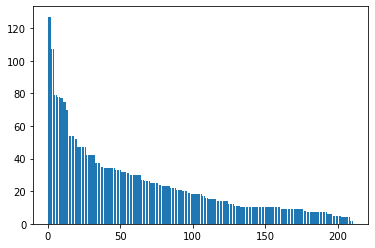

100%|██████████| 5040/5040 [00:20<00:00, 249.62it/s]


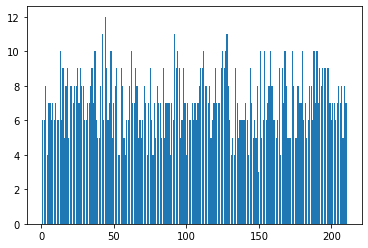

100%|██████████| 5040/5040 [00:19<00:00, 262.18it/s]


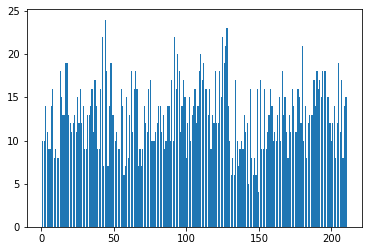

100%|██████████| 5040/5040 [00:20<00:00, 243.11it/s]


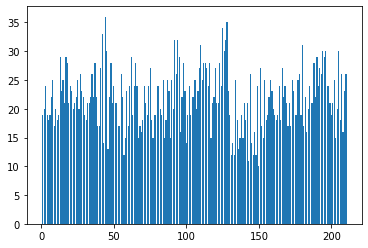

100%|██████████| 5040/5040 [00:19<00:00, 252.57it/s]


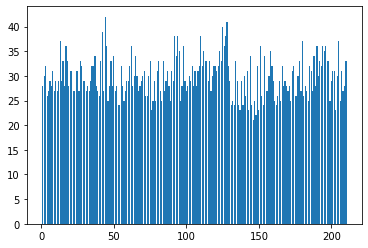

100%|██████████| 5040/5040 [00:21<00:00, 237.72it/s]


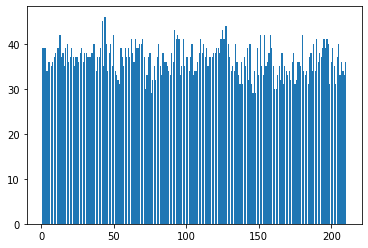

  0%|          | 25/5040 [00:00<00:20, 245.34it/s]

[[0 1 1 0 1 1 1]
 [1 0 0 1 0 0 1]
 [0 0 0 1 1 1 0]
 [1 1 0 0 0 0 0]
 [0 1 1 1 0 1 1]
 [1 1 1 1 0 0 0]
 [1 0 0 0 0 1 0]]


100%|██████████| 5040/5040 [00:22<00:00, 228.31it/s]


[0, 4, 5, 2, 3, 1, 6]    764
[0, 2, 4, 5, 3, 1, 6]    511
[0, 4, 1, 6, 5, 2, 3]    464
[0, 4, 5, 1, 6, 2, 3]    337
[0, 4, 1, 2, 6, 5, 3]    328
[0, 4, 6, 5, 1, 2, 3]    313
[0, 4, 2, 5, 3, 1, 6]    289
[0, 4, 6, 5, 2, 3, 1]    264
[0, 4, 6, 2, 5, 3, 1]    247
[0, 2, 4, 1, 6, 5, 3]    221
[0, 4, 1, 6, 2, 5, 3]    193
[0, 4, 5, 1, 2, 3, 6]    153
[0, 4, 5, 2, 1, 6, 3]    132
[0, 4, 6, 2, 5, 1, 3]    132
[0, 2, 4, 6, 5, 3, 1]    130
[0, 2, 4, 6, 5, 1, 3]    111
[0, 2, 4, 5, 1, 6, 3]    104
[0, 2, 4, 5, 1, 3, 6]     58
[0, 4, 5, 1, 2, 6, 3]     53
[0, 4, 6, 5, 2, 1, 3]     53
[0, 4, 2, 1, 6, 5, 3]     47
[0, 4, 5, 2, 1, 3, 6]     45
[0, 4, 2, 6, 5, 3, 1]     30
[0, 4, 2, 6, 5, 1, 3]     25
[0, 4, 2, 5, 1, 6, 3]     22
[0, 4, 2, 5, 1, 3, 6]     14
dtype: int64


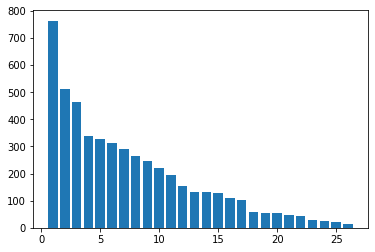

100%|██████████| 5040/5040 [00:20<00:00, 247.05it/s]


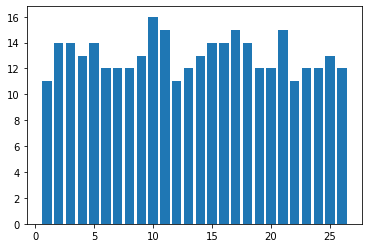

100%|██████████| 5040/5040 [00:21<00:00, 229.97it/s]


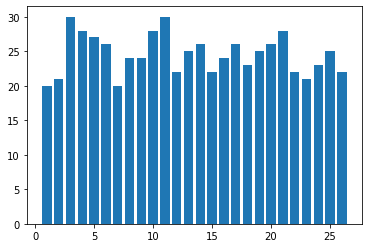

100%|██████████| 5040/5040 [00:20<00:00, 249.27it/s]


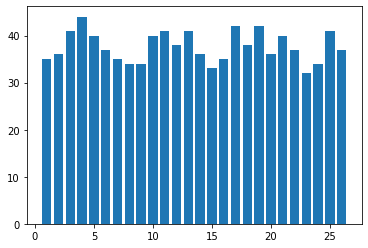

100%|██████████| 5040/5040 [00:20<00:00, 246.78it/s]


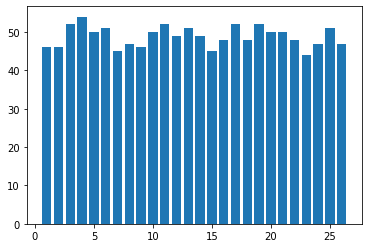

100%|██████████| 5040/5040 [00:20<00:00, 243.55it/s]


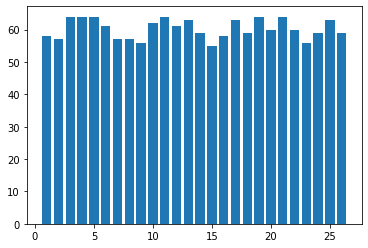

  0%|          | 23/5040 [00:00<00:22, 226.44it/s]

[[0 1 1 0 0 0 0]
 [0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0]
 [1 0 0 0 1 1 0]
 [0 0 1 0 0 1 1]
 [1 0 1 0 1 0 1]
 [0 1 1 1 1 0 0]]


100%|██████████| 5040/5040 [00:21<00:00, 233.62it/s]


[5, 6, 3, 0, 1, 4, 2]    1160
[5, 6, 3, 4, 0, 1, 2]     800
[5, 6, 3, 0, 4, 1, 2]     497
[3, 5, 0, 1, 6, 4, 2]     424
[3, 5, 0, 1, 4, 6, 2]     357
[6, 3, 5, 0, 1, 4, 2]     316
[3, 4, 5, 0, 1, 6, 2]     313
[3, 4, 5, 0, 6, 1, 2]     124
[3, 5, 0, 4, 1, 6, 2]     123
[6, 3, 5, 0, 4, 1, 2]     105
[3, 4, 5, 6, 0, 1, 2]     104
[6, 3, 4, 5, 0, 1, 2]     104
[3, 5, 0, 6, 1, 4, 2]     103
[3, 5, 0, 4, 6, 1, 2]      99
[3, 5, 0, 6, 4, 1, 2]      85
[3, 5, 6, 0, 1, 4, 2]      83
[6, 3, 5, 4, 0, 1, 2]      78
[3, 5, 4, 0, 1, 6, 2]      58
[3, 5, 6, 4, 0, 1, 2]      38
[3, 5, 6, 0, 4, 1, 2]      27
[3, 5, 4, 6, 0, 1, 2]      23
[3, 5, 4, 0, 6, 1, 2]      19
dtype: int64


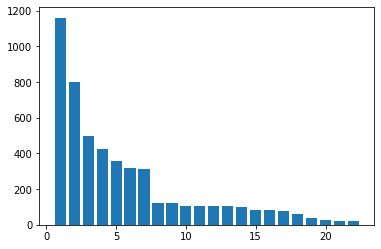

100%|██████████| 5040/5040 [00:20<00:00, 245.15it/s]


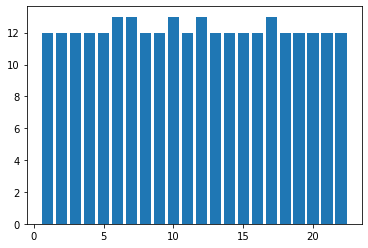

100%|██████████| 5040/5040 [00:22<00:00, 228.17it/s]


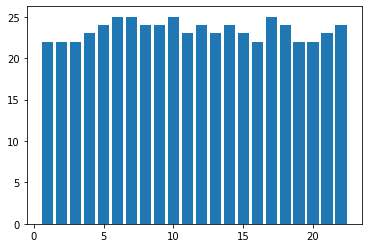

100%|██████████| 5040/5040 [00:22<00:00, 228.29it/s]


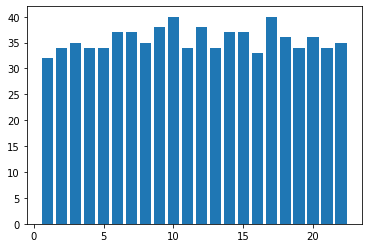

100%|██████████| 5040/5040 [00:22<00:00, 226.19it/s]


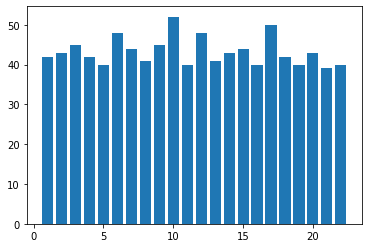

 22%|██▏       | 1104/5040 [00:04<00:15, 258.62it/s]

In [ ]:
#test_rand_D(BinaryFlipNoise(0.5), 4)
test_rand_D_correlate_sensitivity(BinaryFlipNoise(0.5), 4)

## Normal Resampling Noise

In [ ]:
test_rand_D(NormalResamplingNoise(0.5), 4)